In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [24]:
data = pd.read_csv('UrbanEdgeApparel.csv')
data.dropna(subset=['Order Date'], inplace=True)

data['Order Date'] = pd.to_datetime(data['Order Date'])


In [25]:
data_aggregated = data.resample('M', on='Order Date').sum()

In [10]:
# Convert 'Order Date' to datetime
data['Order Date'] = pd.to_datetime(data['Order Date'])

# Extract month and year
data['Order Month'] = data['Order Date'].dt.month
data['Order Year'] = data['Order Date'].dt.year

data['Total Months'] = data['Order Year'] * 12 + data['Order Month'] - data['Order Year'].min() * 12

# Aggregate sales data
aggregate_data = data.groupby(['Total Months']).agg({
    'Product Quantity': 'sum',
    'Total Selling Price': 'sum'
}).reset_index()


aggregate_data['average price'] = aggregate_data['Total Selling Price'] / aggregate_data['Product Quantity']

In [11]:
aggregate_data

,Total Months,Product Quantity,Total Selling Price,average price
0,4,1474,8061.80,5.469335
1,5,5138,21645.75,4.212875
2,6,2967,15165.90,5.111527
3,7,4325,20203.14,4.671246
4,8,1720,8505.79,4.945227
...,...,...,...,...
129,133,6925,32623.68,4.711001
130,134,4326,22483.28,5.197245
131,135,10605,50443.92,4.756617
132,136,8952,45386.64,5.070000


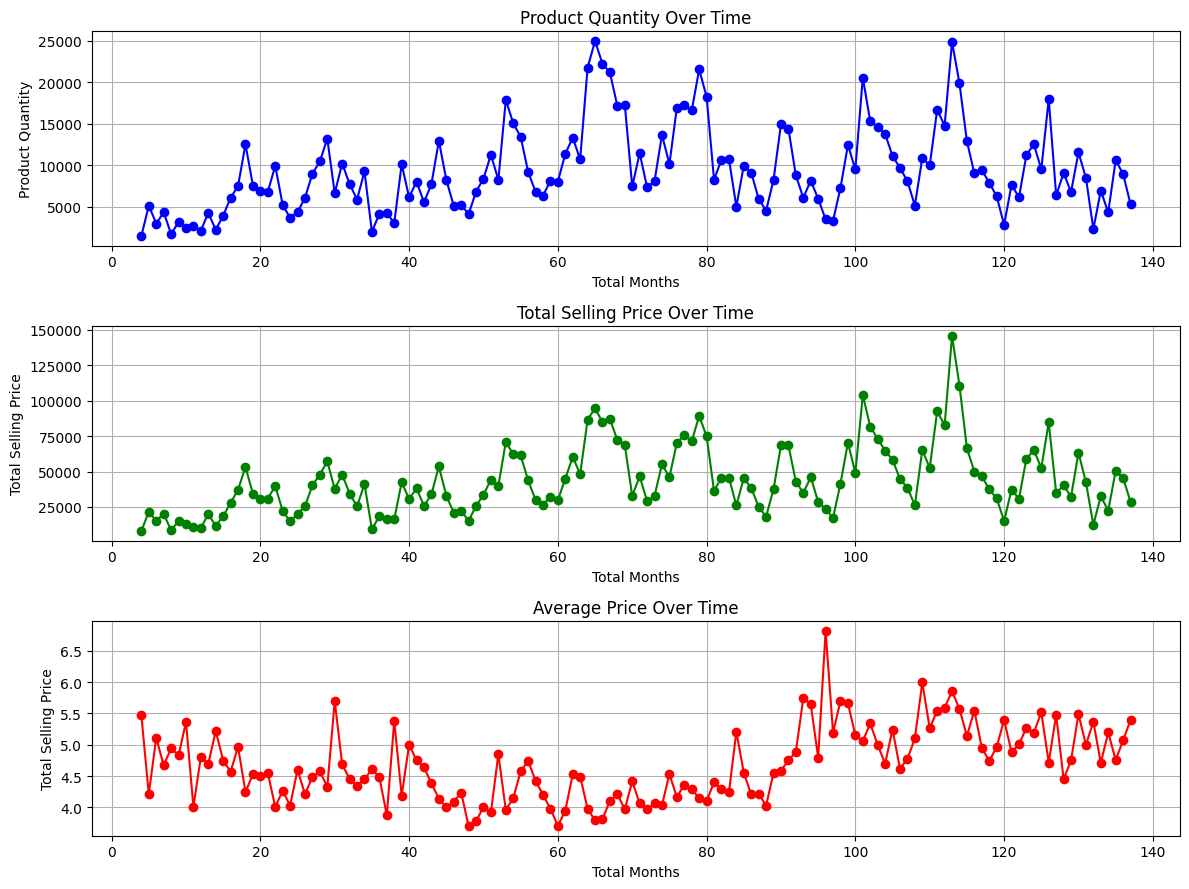

In [12]:
# Plotting the aggregated data to see how quantity and selling price change over time
plt.figure(figsize=(12, 9))

# Plot Product Quantity over time
plt.subplot(3, 1, 1)
plt.plot(aggregate_data['Total Months'], aggregate_data['Product Quantity'], marker='o', linestyle='-', color='b')
plt.title('Product Quantity Over Time')
plt.xlabel('Total Months')
plt.ylabel('Product Quantity')
plt.grid(True)

# Plot Total Selling Price over time
plt.subplot(3, 1, 2)
plt.plot(aggregate_data['Total Months'], aggregate_data['Total Selling Price'], marker='o', linestyle='-', color='g')
plt.title('Total Selling Price Over Time')
plt.xlabel('Total Months')
plt.ylabel('Total Selling Price')
plt.grid(True)

# Plot Average Price over time
plt.subplot(3, 1, 3)
plt.plot(aggregate_data['Total Months'], aggregate_data['average price'], marker='o', linestyle='-', color='r')
plt.title('Average Price Over Time')
plt.xlabel('Total Months')
plt.ylabel('Total Selling Price')
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [20]:
# Prepare the data for Prophet model
aggregate_data['ds'] = pd.date_range(start='2013-01-01', periods=len(aggregate_data), freq='M')
aggregate_data['y'] = aggregate_data['Total Selling Price']

# Select only necessary columns for Prophet
prophet_data = aggregate_data[['ds', 'y']]

In [14]:
from prophet import Prophet

# Initialize the Prophet model
model = Prophet()

# Fit the model
model.fit(prophet_data)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp35jxo80n/a4hf5qeu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp35jxo80n/ogb98bhh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54967', 'data', 'file=/tmp/tmp35jxo80n/a4hf5qeu.json', 'init=/tmp/tmp35jxo80n/ogb98bhh.json', 'output', 'file=/tmp/tmp35jxo80n/prophet_modela7mdbe6b/prophet_model-20240519183024.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [15]:
# Create a dataframe for future dates
future_dates = model.make_future_dataframe(periods=24, freq='M')

# Make predictions
forecast = model.predict(future_dates)

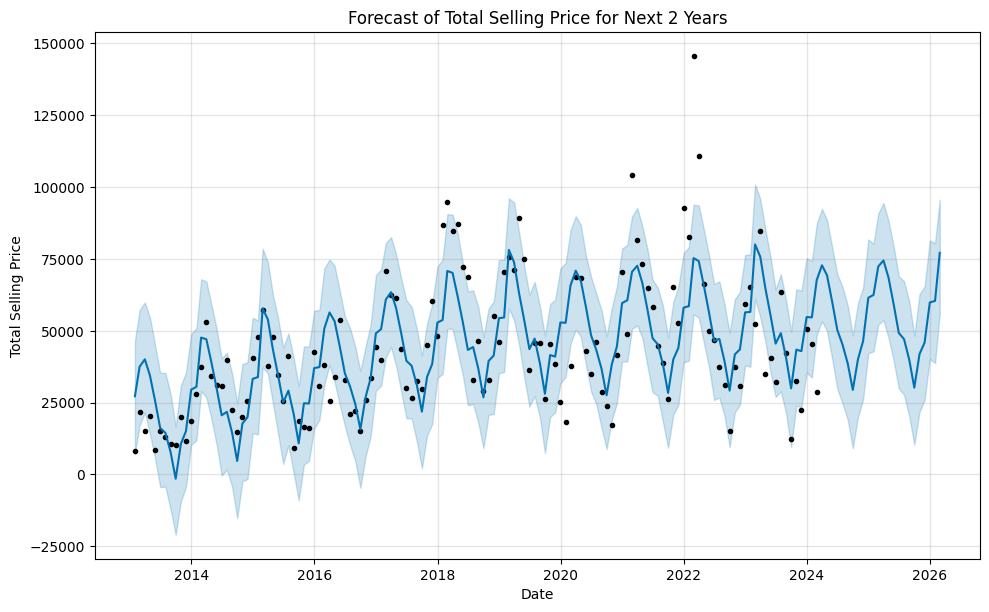

In [16]:
import matplotlib.pyplot as plt

# Plot the forecast
model.plot(forecast)

plt.title('Forecast of Total Selling Price for Next 2 Years')
plt.xlabel('Date')
plt.ylabel('Total Selling Price')
plt.show()

In [17]:
# Use the last 24 months as the test set and the rest as the training set
train_data = prophet_data.iloc[:-24]
test_data = prophet_data.iloc[-24:]


In [18]:
# Initialize the Prophet model
model = Prophet()

# Fit the model on the training data
model.fit(train_data)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp35jxo80n/xq7sp5mn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp35jxo80n/wtykt49l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49352', 'data', 'file=/tmp/tmp35jxo80n/xq7sp5mn.json', 'init=/tmp/tmp35jxo80n/wtykt49l.json', 'output', 'file=/tmp/tmp35jxo80n/prophet_model84od8f_s/prophet_model-20240519183033.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Load data
data = pd.read_csv('UrbanEdgeApparel.csv')
data.dropna(subset=['Order Date'], inplace=True)
data['Order Date'] = pd.to_datetime(data['Order Date'])

# Aggregate data monthly
data_aggregated = data.resample('M', on='Order Date').sum()

# Extract month and year, create total months
data['Order Month'] = data['Order Date'].dt.month
data['Order Year'] = data['Order Date'].dt.year
data['Total Months'] = data['Order Year'] * 12 + data['Order Month'] - data['Order Year'].min() * 12

# Aggregate sales data
aggregate_data = data.groupby(['Total Months']).agg({
    'Product Quantity': 'sum',
    'Total Selling Price': 'sum'
}).reset_index()
aggregate_data['average price'] = aggregate_data['Total Selling Price'] / aggregate_data['Product Quantity']



DEBUG:cmdstanpy:input tempfile: /tmp/tmp35jxo80n/0s8hr53p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp35jxo80n/60khdrbo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56084', 'data', 'file=/tmp/tmp35jxo80n/0s8hr53p.json', 'init=/tmp/tmp35jxo80n/60khdrbo.json', 'output', 'file=/tmp/tmp35jxo80n/prophet_model0u9kgsg8/prophet_model-20240519183958.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:39:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:39:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Absolute Error (MAE): 0.779051222237657
Mean Squared Error (MSE): 0.7748214169379359
Root Mean Squared Error (RMSE): 0.8802394088757535
Mean Absolute Percentage Error (MAPE): 15.728340645529313%


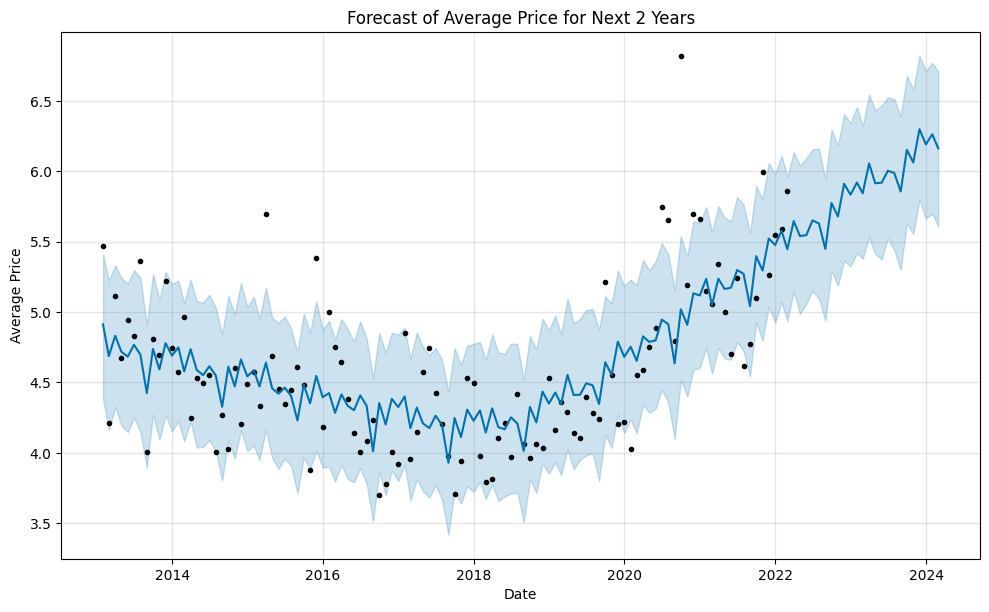

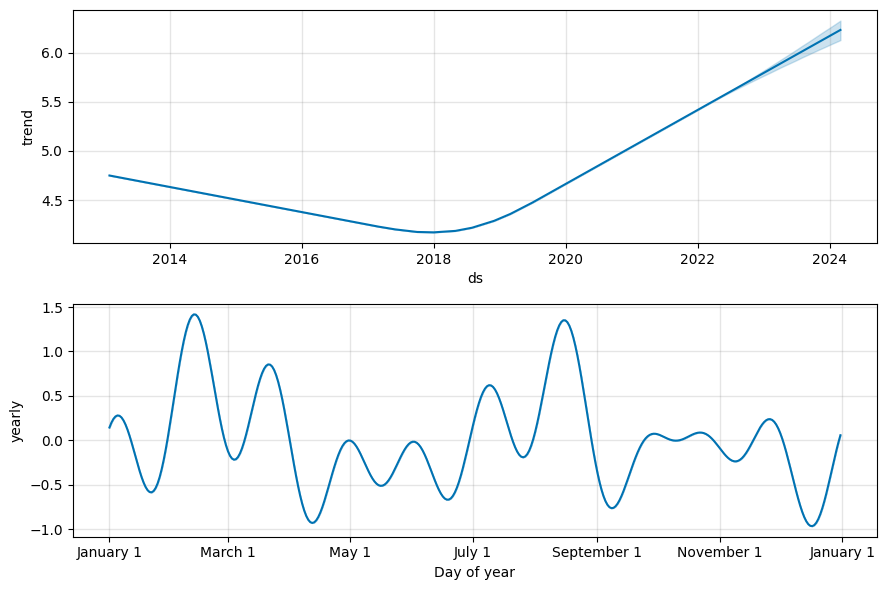

In [29]:
# Prepare the data for Prophet model
aggregate_data['ds'] = pd.date_range(start='2013-01-01', periods=len(aggregate_data), freq='M')
aggregate_data['y'] = aggregate_data['average price']
prophet_data = aggregate_data[['ds', 'y']]

# Use the last 24 months as the test set and the rest as the training set
train_data = prophet_data.iloc[:-24]
test_data = prophet_data.iloc[-24:]

# Initialize the Prophet model with yearly seasonality
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)

# Fit the model on the training data
model.fit(train_data)

# Create a dataframe for future dates in the test period
future_dates_test = pd.DataFrame(test_data['ds'])

# Make predictions on the test data
forecast_test = model.predict(future_dates_test)

# Extract the predicted values
y_pred = forecast_test['yhat'].values

# Extract the actual values from the test set
y_true = test_data['y'].values

# Calculate error metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Create a dataframe for future dates
future_dates = model.make_future_dataframe(periods=24, freq='M')

# Make predictions
forecast = model.predict(future_dates)

# Plot the forecast
model.plot(forecast)
plt.title('Forecast of Average Price for Next 2 Years')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.show()

# Plot the forecast components
model.plot_components(forecast)
plt.show()


DEBUG:cmdstanpy:input tempfile: /tmp/tmp35jxo80n/w3vggte0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp35jxo80n/haq1sj_d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16651', 'data', 'file=/tmp/tmp35jxo80n/w3vggte0.json', 'init=/tmp/tmp35jxo80n/haq1sj_d.json', 'output', 'file=/tmp/tmp35jxo80n/prophet_modelbzh4tvtx/prophet_model-20240519184042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Absolute Error (MAE): 5080.358449818518
Mean Squared Error (MSE): 35573431.721430846
Root Mean Squared Error (RMSE): 5964.346713717341
Mean Absolute Percentage Error (MAPE): 83.64259856528182%


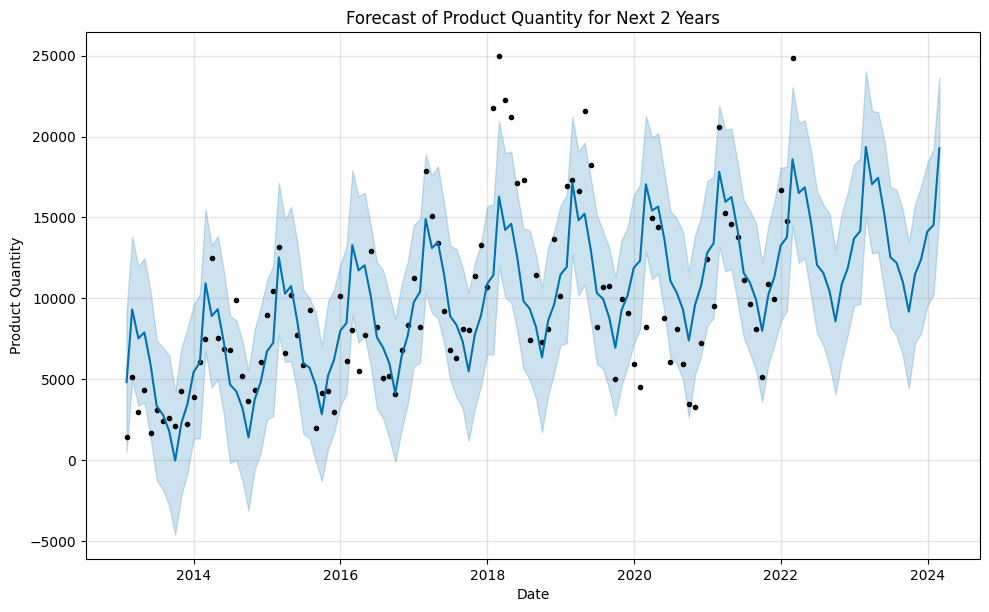

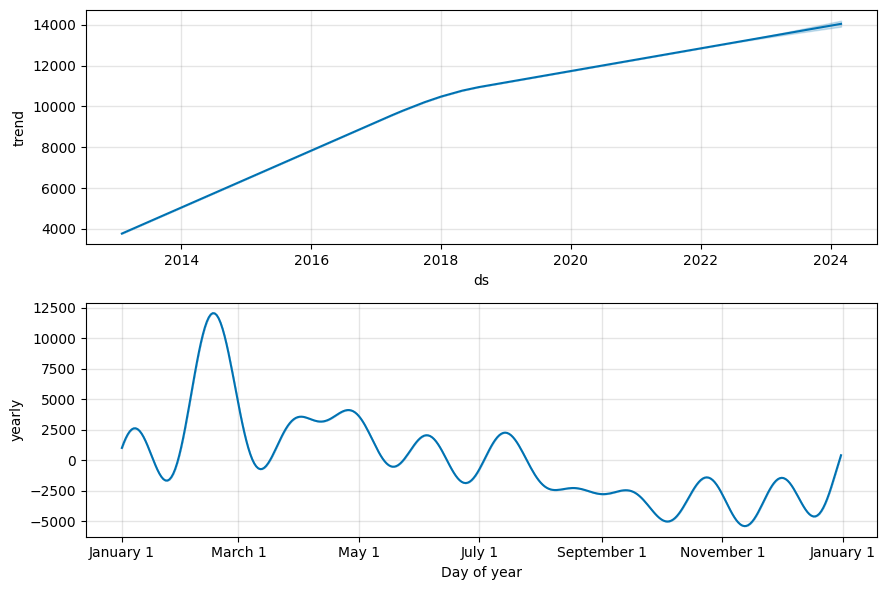

In [30]:
# Prepare the data for Prophet model
aggregate_data['ds'] = pd.date_range(start='2013-01-01', periods=len(aggregate_data), freq='M')
aggregate_data['y'] = aggregate_data['Product Quantity']
prophet_data = aggregate_data[['ds', 'y']]

# Use the last 24 months as the test set and the rest as the training set
train_data = prophet_data.iloc[:-24]
test_data = prophet_data.iloc[-24:]

# Initialize the Prophet model with yearly seasonality
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)

# Fit the model on the training data
model.fit(train_data)

# Create a dataframe for future dates in the test period
future_dates_test = pd.DataFrame(test_data['ds'])

# Make predictions on the test data
forecast_test = model.predict(future_dates_test)

# Extract the predicted values
y_pred = forecast_test['yhat'].values

# Extract the actual values from the test set
y_true = test_data['y'].values

# Calculate error metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Create a dataframe for future dates
future_dates = model.make_future_dataframe(periods=24, freq='M')

# Make predictions
forecast = model.predict(future_dates)

# Plot the forecast
model.plot(forecast)
plt.title('Forecast of Product Quantity for Next 2 Years')
plt.xlabel('Date')
plt.ylabel('Product Quantity')
plt.show()

# Plot the forecast components
model.plot_components(forecast)
plt.show()
